# GitHub Actions Information Needs taxonomy

## I. Dataset preparation

### 1. Data Filtering

There are three subsets of data. They correspond to filter by title, body, and tags. 
1. posts_by_title: Posts containing "Github Actions" or its variants in the question title (github actions, github-action, Github actions, Github-actions, Github Actions, Github-Actions).
2. posts_by_body: Posts containing "Github Actions" or its variants in the question body.
3. posts_by_tags: Posts tagged with any of of github actions tag list ('github-actions', 'building-github-actions', 'github-actions-self-hosted-runners', 'github-actions-runners', 'github-actions-services', 'github-actions-artifacts', 'github-actions-reusable-workflows', 'github-actions-workflows', 'github-actions-marketplace')

In [110]:
import pandas as pd
import numpy as np

In [111]:
# Posts filtered by three filters: Title, Body, and tags.
posts_by_title = pd.read_json('data/posts_by_title.json')
posts_by_body = pd.read_json('data/posts_by_body.json')
posts_by_tags = pd.read_json('data/posts_by_tags.json')
posts_by_title.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)
posts_by_body.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)
posts_by_tags.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)

In [112]:
posts_by_body = posts_by_body[posts_by_body['post_type_id']==1] # Keeping only post bodies that correspond to question bodies, removing answers bodies.
posts_by_tags.describe()

id  post_type_id  accepted_answer_id  parent_id        score  \
count  9.873000e+03        9873.0        3.670000e+03        0.0  9873.000000   
mean   7.126080e+07           1.0        7.022708e+07        NaN     2.747392   
std    5.184317e+06           0.0        5.424942e+06        NaN    11.666862   
min    5.417676e+07           1.0        5.417763e+07        NaN    -6.000000   
25%    6.796411e+07           1.0        6.622763e+07        NaN     0.000000   
50%    7.263306e+07           1.0        7.129186e+07        NaN     1.000000   
75%    7.562319e+07           1.0        7.493441e+07        NaN     2.000000   
max    7.759369e+07           1.0        7.758567e+07        NaN   348.000000   

          view_count  owner_user_id  last_editor_user_id  answer_count  \
count    9873.000000   9.801000e+03         4.271000e+03   9873.000000   
mean     2217.544718   8.707827e+06         6.605726e+06      0.981363   
std      8988.151347   6.554179e+06         6.039375e+06      1.119418   
min         5.000000   9.100000e+01        -1.000000e+00      0.000000   
25%       136.000000   2.628868e+06         1.623876e+06      0.000000   
50%       459.000000   7.764329e+06         4.290962e+06      1.000000   
75%      1385.000000   1.383621e+07         1.023495e+07      1.000000   
max    321529.000000   2.302257e+07         2.296569e+07     35.000000   

       comment_count  
count    9873.000000  
mean        1.657753  
std         2.394376  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         2.000000  
max        26.000000

In [113]:
# Number of different datasets
print("Number of posts filtered by title:", len(posts_by_title))
print("Number of posts filtered by body:", len(posts_by_body))
print("Number of posts filtered by tags :", len(posts_by_tags))
df_union = pd.concat([posts_by_tags, posts_by_title, posts_by_body]).drop_duplicates().reset_index(drop=True)
print("Number of posts of the union:", len(df_union))
df_merged_1 = pd.merge(posts_by_tags, posts_by_title, how='inner')
df_intersection = pd.merge(df_merged_1, posts_by_body, how='inner')
print("Number of posts of the intersection:", len(df_intersection))

Number of posts filtered by title: 4538
Number of posts filtered by body: 6297
Number of posts filtered by tags : 9873
Number of posts of the union: 11323
Number of posts of the intersection: 2903


In [114]:
# Number of questions tagged with the primary tag 'github-actions'
df_intersection['tags'].str.contains('<github-actions>').value_counts()

tags
True     2894
False       9
Name: count, dtype: int64

### 2. Sampling

- We have decided to use df_intersection because we consider that we are ensuring that the topic is for sure related to GitHub Actions because it is tagged and mentioned in the title and the body question. 

- We decided to select a random sample.

- 340 posts or more are needed to have a confidence level of 95% that the real value is within ±5%.

In [115]:
# Creating the random sample. We are accepting the first 340 posts that we consider are related to the topic.
sample_size = 400
seed = 0
df_sample = df_intersection.sample(n=sample_size, random_state=seed)
print("Sample length: ", df_sample.shape[0])
df_sample.head();

Sample length:  400


### 3. Manual examination

- Two authors examinated the posts manually in order the removing posts that were not GA related or links that did not work. Finally, 340 posts were accepted.

In [116]:
# Creating the files that will be examinated by two evaluators
df_sample[['id', 'link']].assign(evaluator1=np.nan).to_excel('data/sample_eval1.xlsx')
df_sample[['id', 'link']].assign(evaluator2=np.nan).to_excel('data/sample_eval2.xlsx')

In [117]:
# Posts that are accepted by both evaluators were accepted.
sample_reviewed=pd.read_excel('data/sample_eval1_reviewed.xlsx')
sample_reviewed['evaluator2']=pd.read_excel('data/sample_eval2_reviewed.xlsx')['evaluator2']
sample_accepted=sample_reviewed[(sample_reviewed['evaluator1']==1)&(sample_reviewed['evaluator2']==1)].head(340)
sample_accepted = pd.merge(df_intersection, sample_accepted[['id']], on='id', how='inner')
sample_accepted.to_excel('data/sample_accepted.xlsx')
sample_accepted.head(3);

### 4. Coding in sentences

Body text was parsed from html to plain text. Removing code, blocks, or links. Usually images are also links. After that, text was divided in sentences.

In [118]:
from bs4 import BeautifulSoup
import re

def html_to_sentences_df(html_content):
    """
    Parses the provided HTML content, replaces specific tags with placeholders, adjusts paragraph endings, and splits the content into sentences. 
    Returns a pandas DataFrame with each sentence in a separate row.
    
    Parameters:
    - html_content: String containing HTML content.
    
    Returns:
    - DataFrame with each sentence as a separate row.
    """
    
    # Parse the HTML
    soup = BeautifulSoup(html_content, 'html.parser')

    # Replace code blocks, blockquotes, and links with placeholders
    for code in soup.find_all('code'):
        code.replace_with("-CODE-")
    for blockquote in soup.find_all('blockquote'):
        blockquote.replace_with("-BLOCK-")
    for a in soup.find_all('a'):
        a.replace_with("-LINK-")

    # Extract text and replace newline entities
    text = soup.get_text()
    text = text.replace('&#xA;', '\n').strip()

    # Pre-process text to handle ':\\n-CODE-' pattern
    text = re.sub(r':\s*\n-CODE-', ': -CODE-', text)
    text = re.sub(r':\s*\n-BLOCK-', ': -BLOCK-', text)
    text = re.sub(r':\s*\n-LINK-', ': -LINK-', text)
    
    # Adjust paragraph endings where necessary
    pattern = r'(?<![\.\!\?\s])\s*\n'
    text = re.sub(pattern, '.\n', text)

    # Replace ':.' with ':'
    text = text.replace(':.', ':')

    # Split text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text.replace('\n', ' '))

    # Create DataFrame
    df = pd.DataFrame(sentences, columns=['sentence'])
    
    return df

In [119]:
def process_df(sample_df):
    # Initialize an empty DataFrame to hold all sentences
    all_sentences_df = pd.DataFrame()

    # Iterate over each row in the DataFrame
    for index, row in sample_df.iterrows():

        # Process the title and body, assuming they are HTML content
        title_sentences_df = html_to_sentences_df(row['post_title'])
        body_sentences_df = html_to_sentences_df(row['post_body'])

        # Add a column with the index/id of the post
        title_sentences_df['id'] = index
        body_sentences_df['id'] = index

        # Add a column with the index/id of the post
        title_sentences_df['post_id'] = row['id']
        body_sentences_df['post_id'] = row['id']

        # Add a column to indicate the source of the sentences
        title_sentences_df['source'] = 'title'
        body_sentences_df['source'] = 'body'
        
        # Combine title and body sentences
        combined_sentences_df = pd.concat([title_sentences_df, body_sentences_df], ignore_index=True)
        
        # Add the combined sentences to the overall DataFrame
        all_sentences_df = pd.concat([all_sentences_df, combined_sentences_df], ignore_index=True)

        all_sentences_df = all_sentences_df[['id', 'post_id', 'source', 'sentence']]

    return all_sentences_df

all_sentences_df = process_df(sample_accepted) # this df contains all the sentences from the sample of 340 posts.

all_sentences_df

C:\Users\shern\AppData\Local\Temp\ipykernel_27108\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open thi

id   post_id source                                           sentence
0       0  57503578  title  Making pull requests to a GitHub repository au...
1       0  57503578   body  I have a file in a GitHub repository that need...
2       0  57503578   body  As part of a -LINK-, I want to have a bot runn...
3       0  57503578   body  I have a suspicion that the -LINK- can help me...
4       0  57503578   body  I see some official automation workflows that ...
...   ...       ...    ...                                                ...
3171  339  77519735   body                                            -CODE-.
3172  339  77519735   body                         Below is an error message.
3173  339  77519735   body                                            -CODE-.
3174  339  77519735   body  I searched for an error message, but I couldn'...
3175  339  77519735   body      How do I make modifications to work normally?

[3176 rows x 4 columns]

----------------------------------------------------------------

## II. Manual classification

### 1. Pre-classification

We create a pre-categorization using a small sample of 50 posts. 13 categories were established. Afterwards, we classfified the rest of them redefining these categories.

In [120]:
# Creating files for the evaluators

categories = [1, 4, 5, 7, 2, 9, 13, 11, 14, 20, 22, 19, 23]
# Add each new column filled with zeros to the DataFrame
for column in categories:
    all_sentences_df[column] = 0

all_sentences_df.to_excel('data/sentences_eval1.xlsx')
all_sentences_df.to_excel('data/sentences_eval2.xlsx')

In [121]:
classified_sentences_eval1 = pd.read_excel('data/sentences_eval1_reviewed.xlsx')
classified_sentences_eval2 = pd.read_excel('data/sentences_eval2_reviewed.xlsx')

In [122]:
# Kappa-Cohen scores of the evaluators classifications 

import pandas as pd
from sklearn.metrics import cohen_kappa_score

kappa = pd.DataFrame()
for category in classified_sentences_eval1.columns.drop(['Unnamed: 0', 'id', 'post_id', 'source', 'sentence']):
    kappa[category] = [cohen_kappa_score(classified_sentences_eval1[category], classified_sentences_eval2[category])]

kappa

1         4         5         7    2         9         13        11  \
0  0.562396  0.340006  0.326081  0.214155  0.0  0.487878 -0.000294  0.189686   

    14        20       22   19   23  
0  0.0  0.451206  0.36159  0.0  0.0

In [123]:
#sample_json = sample_accepted.to_json(orient='records', lines=False, indent=4)
#print(sample_json)

### 2. Information Needs and Relevant Information taxonomy

After performing manually the taxonomy, we identified 8 Information Needs (DN), and 24 Relevant Information (RI) groups. 
The 8 DN are: Error Handling (EH), Incompatibility (IN), Insufficient Implementation (II), Migration (MI), Functionality Implementation (FI), Orientation (OR), Alternative Solution (AS), and GHA Learning (LE).

In [124]:
DN_list = ['EH', 'IN', 'II', 'MI', 'FI', 'OR', 'AS', 'LE']
sentences_classified = pd.read_excel("data/sentences_taxonomy.xlsx", sheet_name=DN_list)
sample_sentences = pd.DataFrame()
for k in sentences_classified.keys():
    sentences_classified[k].drop_duplicates(inplace=True)
    sample_sentences = pd.concat([sample_sentences, sentences_classified[k]], ignore_index=True)
sample_sentences = pd.concat([sample_sentences, pd.get_dummies(sample_sentences['RI_id'], dtype=int)], axis=1)

In [125]:
sample_sentences.sort_values(by=['sentence_id'], inplace=True)
sample_sentences.drop(['RI_id'], axis=1, inplace=True)

In [126]:
# List of Relevant Information id's
RI_list = sample_sentences.columns[5:]

In [127]:
# Merging duplicated sentences with different RI categories.
agg_dict = dict()
agg_dict['id'] = 'first'
agg_dict['post_id'] = 'first'
agg_dict['source'] = 'first'
agg_dict['sentence'] = 'first'
agg_dict.update({col: 'sum' for col in RI_list})
sample_sentences = sample_sentences.groupby('sentence_id').agg(agg_dict).reset_index()
sample_sentences;

There are 1000 sentences that contain one or more types of Relevant Information.

In [128]:
# Creating a DF with all the sentences of the sample and their categorization

all_sentences_df = all_sentences_df.drop(columns=categories, axis=1)

# Add each new column filled with zeros to the DataFrame
for column in RI_list:
    all_sentences_df[column] = 0
all_sentences_df.index.name = 'sentence_id'

for i in range(len(all_sentences_df)):
    for j in range(len(sample_sentences)):
        if i == sample_sentences.loc[j, 'sentence_id']:
            all_sentences_df.loc[i, RI_list] = sample_sentences.loc[j, RI_list]
all_sentences_df

id   post_id source  \
sentence_id                         
0              0  57503578  title   
1              0  57503578   body   
2              0  57503578   body   
3              0  57503578   body   
4              0  57503578   body   
...          ...       ...    ...   
3171         339  77519735   body   
3172         339  77519735   body   
3173         339  77519735   body   
3174         339  77519735   body   
3175         339  77519735   body   

                                                      sentence  AS1  EH1  EH2  \
sentence_id                                                                     
0            Making pull requests to a GitHub repository au...    0    0    0   
1            I have a file in a GitHub repository that need...    0    0    0   
2            As part of a -LINK-, I want to have a bot runn...    0    0    0   
3            I have a suspicion that the -LINK- can help me...    0    0    0   
4            I see some official automation workflows that ...    0    0    0   
...                                                        ...  ...  ...  ...   
3171                                                   -CODE-.    0    0    0   
3172                                Below is an error message.    0    0    0   
3173                                                   -CODE-.    0    0    0   
3174         I searched for an error message, but I couldn'...    0    0    0   
3175             How do I make modifications to work normally?    0    0    0   

             EH3  EH4  EH5  ...  LE2  LE3  MI1  OR1  OR2  OR3  OR4  OR5  OR6  \
sentence_id                 ...                                                
0              0    0    0  ...    0    0    0    0    0    0    0    0    0   
1              0    0    0  ...    0    0    0    0    0    0    0    0    0   
2              0    0    0  ...    0    0    0    0    0    0    0    0    0   
3              0    0    0  ...    0    0    0    0    0    0    0    0    0   
4              0    0    0  ...    0    0    0    0    0    0    0    0    0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3171           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3172           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3173           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3174           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3175           0    0    0  ...    0    0    0    0    0    0    0    0    0   

             OR7  
sentence_id       
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
3171           0  
3172           0  
3173           0  
3174           0  
3175           0  

[3176 rows x 28 columns]

In [129]:
# Saving results as a json 

grouped = {} #

for index, row in all_sentences_df.iterrows():
    post_id = row['post_id']
    # Structure for each sentence
    sentence_data = {
        'post_id': post_id,
        'source': row['source'],
        'sentence': row['sentence'],
        'DN': {
            'AS': {'AS1': row['AS1']},
            'EH': {'EH1': row['EH1'], 'EH2': row['EH2'], 'EH3': row['EH3'], 'EH4': row['EH4'], 'EH5': row['EH5'], 'EH6': row['EH6'], 'EH7': row['EH7'], 'EH8': row['EH8'], 'EH9': row['EH9']},
            'FI': {'FI1': row['FI1']},
            'II': {'II1': row['II1']},
            'IN': {'IN1': row['IN1']},
            'LE': {'LE1': row['LE1'], 'LE2': row['LE2'], 'LE3': row['LE3']},
            'MI': {'MI1': row['MI1']},
            'OR': {'OR1': row['OR1'], 'OR2': row['OR2'], 'OR3': row['OR3'], 'OR4': row['OR4'], 'OR5': row['OR5'], 'OR6': row['OR6'], 'OR7': row['OR7']}
        }
    }
    # Append to the list for the corresponding post_id in the result dictionary
    if post_id in grouped:
        grouped[post_id].append(sentence_data)
    else:
        grouped[post_id] = [sentence_data]

sample_df = sample_accepted.copy()
sample_df['sentences'] = sample_df['id'].map(grouped)
sample_df

sample_json = sample_df.to_json(orient='records', indent=4)
with open('data/sample_classified.json', 'w') as f:
    f.write(sample_json)
    
print(sample_json)

[
    {
        "id":57503578,
        "post_type_id":1,
        "accepted_answer_id":null,
        "parent_id":null,
        "creation_date":"2019-08-15 00:30:14",
        "score":13,
        "view_count":7788,
        "post_body":"<p>I have a file in a GitHub repository that needs updating occasionally by running a command.<\/p>&#xA;&#xA;<p>As part of a <a href=\"https:\/\/help.github.com\/en\/articles\/configuring-a-workflow\" rel=\"noreferrer\">GitHub Workflows<\/a>, I want to have a bot running a command, and seeing if it creates  a diff on the repo, and if so, make a pull request to the repository automatically. <\/p>&#xA;&#xA;<p>I have a suspicion that the <a href=\"https:\/\/help.github.com\/en\/articles\/configuring-a-workflow\" rel=\"noreferrer\">GitHub Workflows<\/a> can help me do that as GitHub now lets people run arbitrary containers (\"Actions\") that do stuff like builds in a repository. I see some official automation workflows that let you \"label\" and \"comment\" iss

----------------------------------------------------------------

## III. Taxonomy Evaluation

### Orthogonality

According to the references paper: https://dl.acm.org/doi/abs/10.1145/3530019.3535305
They propose a 3-Step Evaluation: Suitable structure, Applicability, and Purpose.
Step 1 evaluates 5 criterias: Laconicity, Ludicity, Completeness, Soundness, and Orthogonality Matrix.

In [130]:
# Calculates the orthogonality matrix

def calculate_orthogonality_matrix(df, class_columns):
    R = df[class_columns].values
    num_classes = R.shape[1]
    orthogonality_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                # Check if there is any overlap between classes i and j
                #if np.any(R[:, i] & R[:, j]):
                #    orthogonality_matrix[i, j] = 1.0
                # orthogonality_matrix[i, j] = np.sum(R[:, i] & R[:, j])

                # Calculate the percentage with respect to the number of elements in class i
                overlap_count = np.sum(R[:, i] & R[:, j])
                total_elements_class_i = np.sum(R[:, i])
                if total_elements_class_i > 0:
                    orthogonality_matrix[i, j] = (overlap_count / total_elements_class_i) * 100
                else:
                    orthogonality_matrix[i, j] = 0.0

    return orthogonality_matrix

orthogonality_matrix = calculate_orthogonality_matrix(sample_sentences, RI_list)
print(f'Relevant Information:\n{RI_list[:]}')
print(f'Orthogonality Matrix:\n{orthogonality_matrix}')

Relevant Information:
Index(['AS1', 'EH1', 'EH2', 'EH3', 'EH4', 'EH5', 'EH6', 'EH7', 'EH8', 'EH9',
       'FI1', 'II1', 'IN1', 'LE1', 'LE2', 'LE3', 'MI1', 'OR1', 'OR2', 'OR3',
       'OR4', 'OR5', 'OR6', 'OR7'],
      dtype='object')
Orthogonality Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  1  0  5  4  5 20 12  7  3  2  4  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0 62  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0 25  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0 35  0  7  0  0  7  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  6  1  6  0  0  1  8  2  5  5  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 45  0  0  0  0  0  9  0  9  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  1  1  1  1  0  1  4  4  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0 11  0  1  0  1  0  1  4  3  0  0  0  0  1  0  0  0  0  0]
 [ 0 11  0  1  0  3  1  4  1  0  1  0  1  0  0  0  0  0  1  0  0  0  

### Scenario 1 and 2: using all the sentences and only relevant sentences 

In [131]:
# Calculate Laconicity, Completeness, Lucidity, and Soundness

def calculate_evaluation_structure(df_sentences):
    sum_RIs = np.sum(df_sentences[RI_list].values, axis=0)
    sum_sentences = np.sum(df_sentences[RI_list].values, axis=1)
    laconicity = np.mean(sum_sentences <=1)
    completeness = np.mean(sum_sentences >= 1)
    lucidity = np.mean(sum_RIs <= 1)
    soundness = np.mean(sum_RIs >= 1)
    dict = {'Laconicity': laconicity, 'Completeness': completeness, 'Lucidity': lucidity, 'Soundness': soundness}
    return dict

In [132]:
print("Using only relevant sentences: ", calculate_evaluation_structure(sample_sentences))
print("Using all the sentences: ", calculate_evaluation_structure(all_sentences_df))

Using only relevant sentences:  {'Laconicity': 0.882, 'Completeness': 1.0, 'Lucidity': 0.0, 'Soundness': 1.0}
Using all the sentences:  {'Laconicity': 0.9628463476070529, 'Completeness': 0.3148614609571788, 'Lucidity': 0.0, 'Soundness': 1.0}


### Scenario 3 and 4: By Post with and without irrelevant sentences

In [133]:
# Create metric plots

import matplotlib.pyplot as plt

def plot_metrics(df):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot Laconicity vs post_id
    axs[0, 0].plot(df['post_id'], df['Laconicity'], marker='o', linestyle='None')
    axs[0, 0].set_xlabel('Post ID')
    axs[0, 0].set_ylabel('Laconicity')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].set_title('Laconicity vs Post ID')
    axs[0, 0].grid(True)

    # Plot Completeness vs post_id
    axs[0, 1].plot(df['post_id'], df['Completeness'], marker='o', linestyle='None')
    axs[0, 1].set_xlabel('Post ID')
    axs[0, 1].set_ylabel('Completeness')
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].set_title('Completeness vs Post ID')
    axs[0, 1].grid(True)

    # Plot Lucidity vs post_id
    axs[1, 0].plot(df['post_id'], df['Lucidity'], marker='o', linestyle='None')
    axs[1, 0].set_xlabel('Post ID')
    axs[1, 0].set_ylabel('Lucidity')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].set_title('Lucidity vs Post ID')
    axs[1, 0].grid(True)

    # Plot Soundness vs post_id
    axs[1, 1].plot(df['post_id'], df['Soundness'], marker='o', linestyle='None')
    axs[1, 1].set_xlabel('Post ID')
    axs[1, 1].set_ylabel('Soundness')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].set_title('Soundness vs Post ID')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

Considering only relevant sentences:

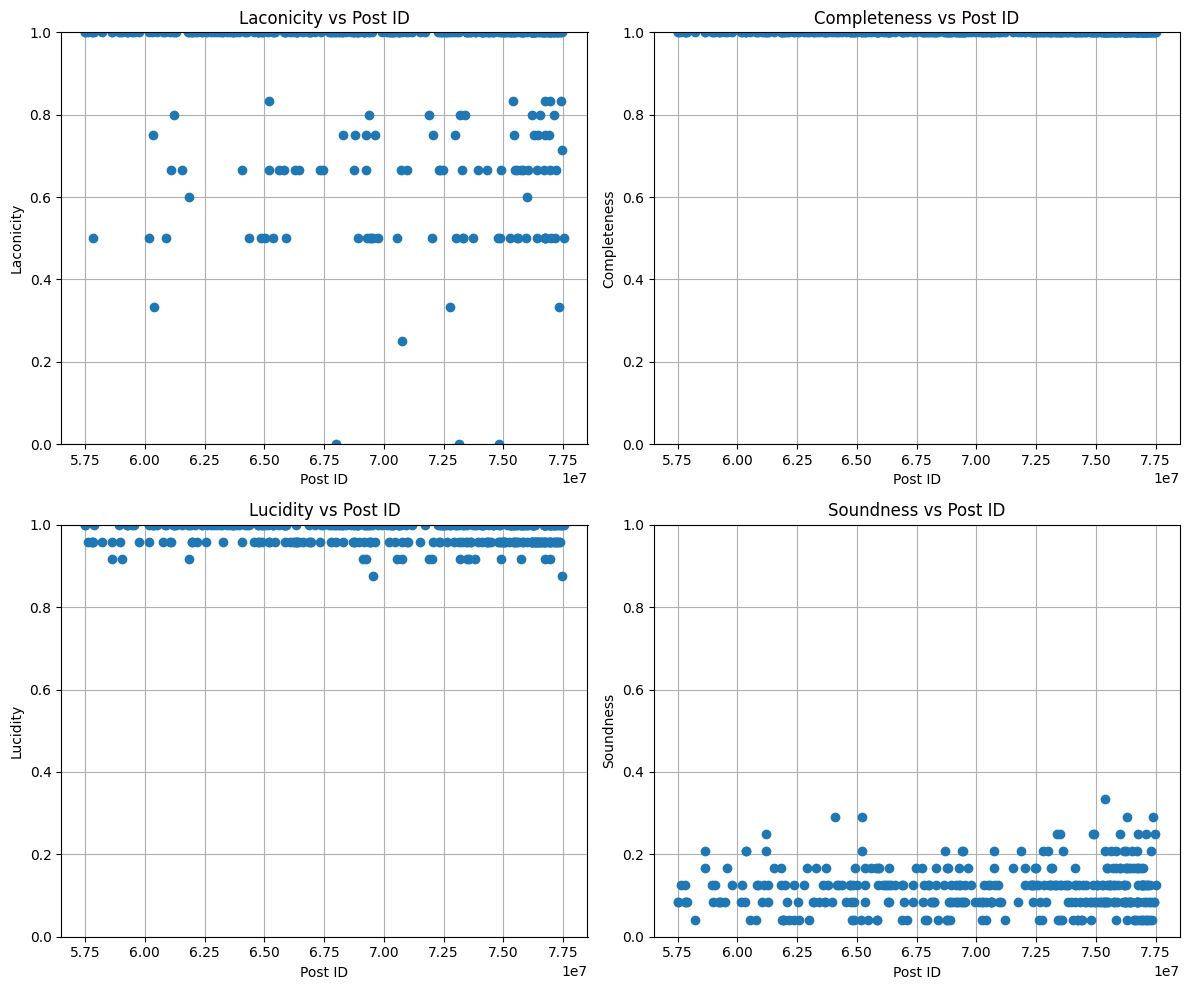

Mean values for the structure parameters:
 post_id         7.029749e+07
Laconicity      8.824280e-01
Completeness    1.000000e+00
Lucidity        9.794162e-01
Soundness       1.163922e-01
dtype: float64


In [134]:
metrics = sample_sentences.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

Considering all the sentences:

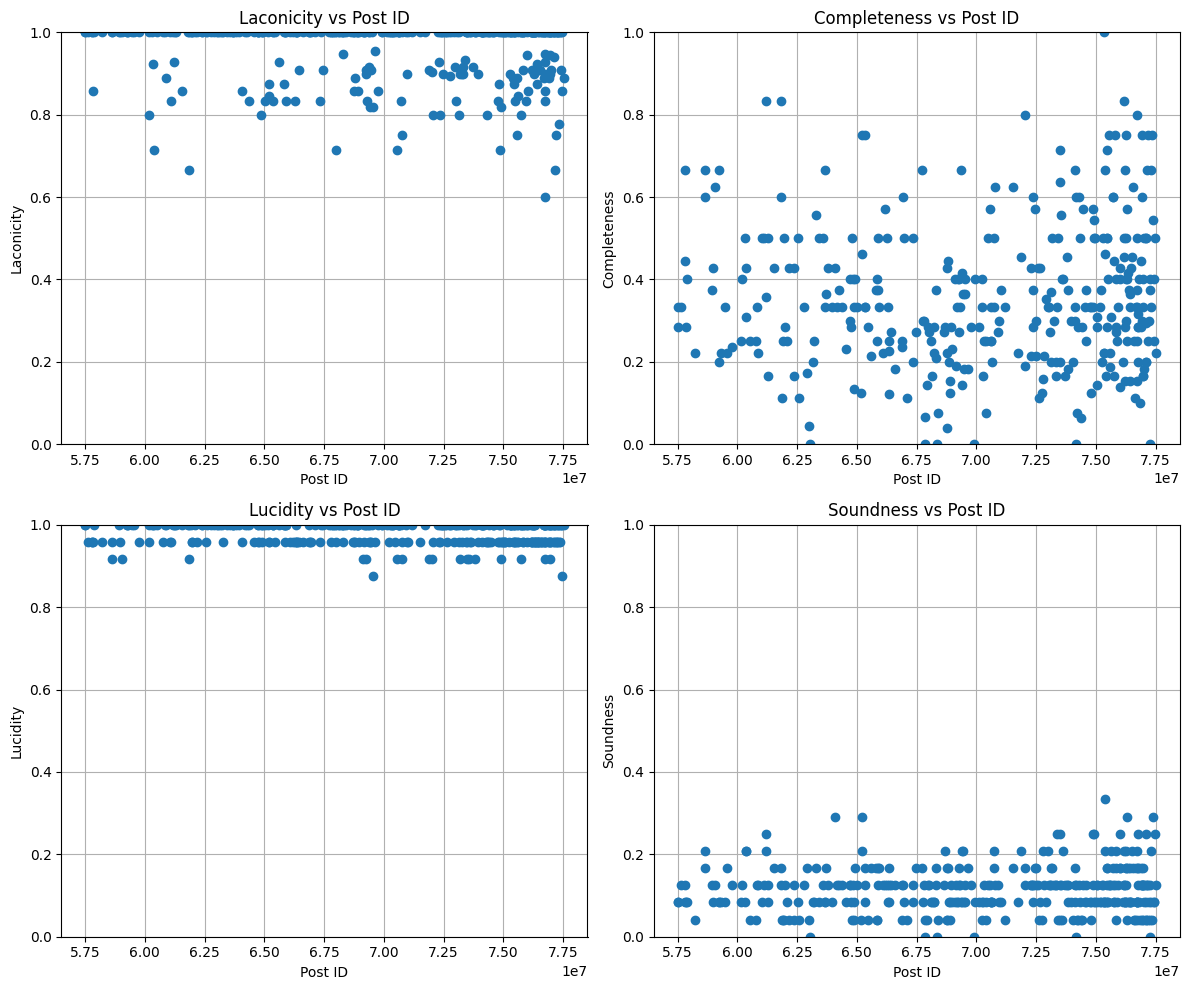

Mean values for the structure parameters:
 post_id         7.029407e+07
Laconicity      9.590664e-01
Completeness    3.559708e-01
Lucidity        9.797794e-01
Soundness       1.143382e-01
dtype: float64


In [135]:
metrics = all_sentences_df.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

### Scenario 5: Adding a new category for Non-Relevant 'NR' sentences

{'Laconicity': 0.9628463476070529, 'Completeness': 1.0, 'Lucidity': 0.0, 'Soundness': 1.0}


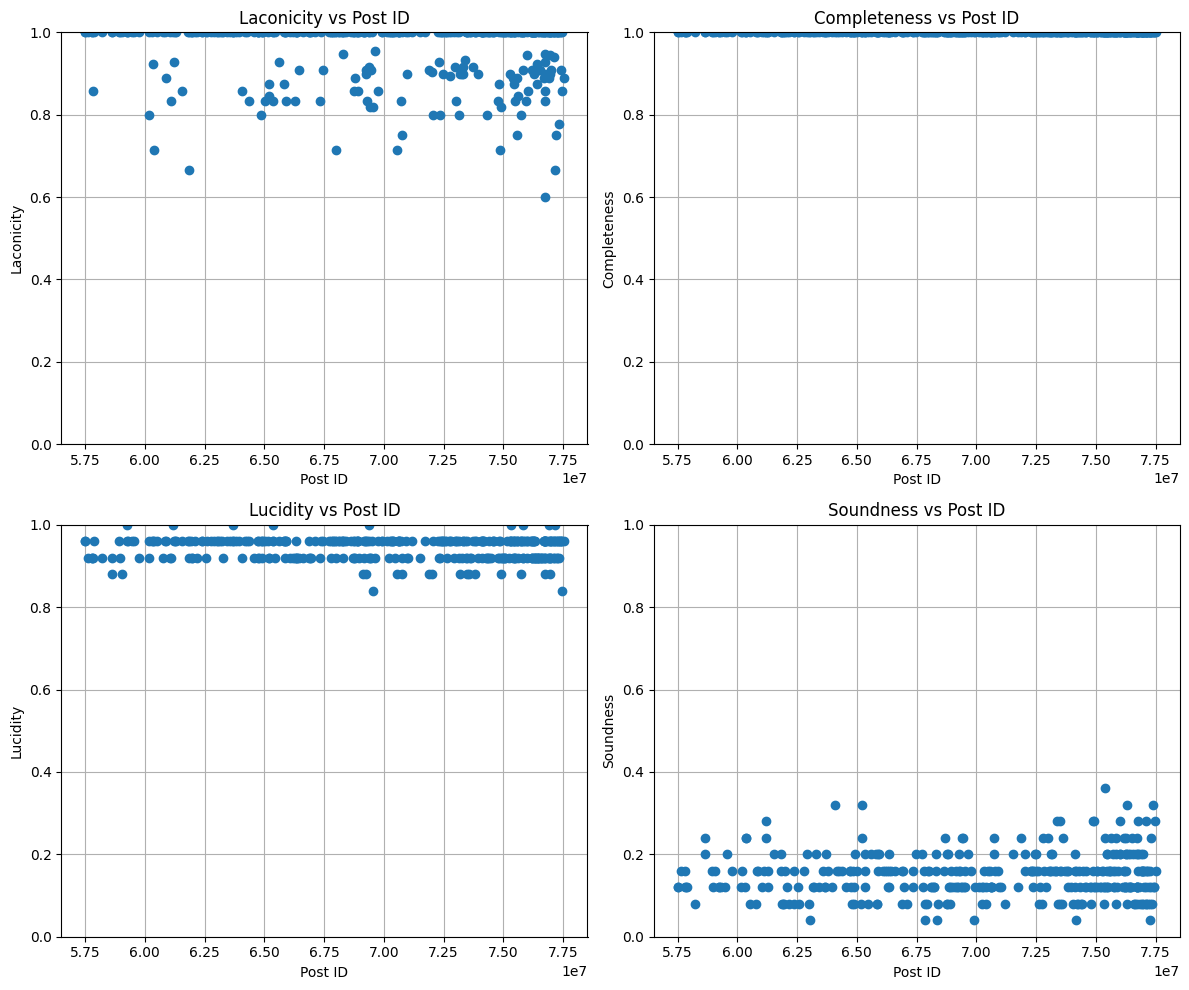

Mean values for the structure parameters:
 post_id         7.029407e+07
Laconicity      9.590664e-01
Completeness    1.000000e+00
Lucidity        9.424706e-01
Soundness       1.496471e-01
dtype: float64


In [136]:
all_sentences_plus_NR = all_sentences_df.copy()
all_sentences_plus_NR['NR'] = all_sentences_plus_NR[RI_list].sum(axis=1)+1
all_sentences_plus_NR.loc[all_sentences_plus_NR['NR'] > 1, 'NR'] = 0

sample_sentences_plus_NR = sample_sentences.copy()
sample_sentences_plus_NR['NR'] = sample_sentences_plus_NR[RI_list].sum(axis=1)+1
sample_sentences_plus_NR.loc[sample_sentences_plus_NR['NR'] > 1, 'NR'] = 0


def calculate_evaluation_structure(df_sentences):
    RI_list_NR = RI_list.append(pd.Index(['NR']))
    sum_RIs = np.sum(df_sentences[RI_list_NR].values, axis=0)
    sum_sentences = np.sum(df_sentences[RI_list_NR].values, axis=1)
    laconicity = np.mean(sum_sentences <=1)
    completeness = np.mean(sum_sentences >= 1)
    lucidity = np.mean(sum_RIs <= 1)
    soundness = np.mean(sum_RIs >= 1)
    dict = {'Laconicity': laconicity, 'Completeness': completeness, 'Lucidity': lucidity, 'Soundness': soundness}
    return dict


print(calculate_evaluation_structure(all_sentences_plus_NR))

metrics = all_sentences_plus_NR.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

----------------------------------------------------------------

# IV. Results and Analysis

### 1. Basic Statistics

In [137]:
# Define a mapping from RI columns to DN categories
dn_mapping = {
    'EH': ['EH1', 'EH2', 'EH3', 'EH4', 'EH5', 'EH6', 'EH7', 'EH8', 'EH9'],
    'IN': ['IN1'],
    'II': ['II1'],
    'MI': ['MI1'],
    'FI': ['FI1'],
    'OR': ['OR1', 'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7'],
    'AS': ['AS1'],
    'LE': ['LE1', 'LE2', 'LE3']
}

In [138]:
# Calculate the total number of sentences
total_sentences = all_sentences_df.shape[0]

# Calculate the number of sentences without any RI
ri_columns = [col for sublist in dn_mapping.values() for col in sublist]
sentences_without_ri = all_sentences_df[ri_columns].sum(axis=1) == 0
num_sentences_without_ri = sentences_without_ri.sum()

# Display the results
print(f"Total number of sentences: {total_sentences}")
print(f"Number of sentences without any RI: {num_sentences_without_ri}")


Total number of sentences: 3176
Number of sentences without any RI: 2176


In [139]:
# Calculate the counts for each RI category
ri_columns = all_sentences_df.columns[4:]  # Assuming RI columns start from the 5th column onwards
ri_counts = all_sentences_df[ri_columns].sum()

# Convert the counts to a DataFrame for better readability
ri_counts_df = ri_counts.reset_index()
ri_counts_df.columns = ['RI_Category', 'Count']

ri_counts_df

RI_Category  Count
0          AS1      8
1          EH1     94
2          EH2      8
3          EH3      4
4          EH4     14
5          EH5     80
6          EH6     11
7          EH7     67
8          EH8     63
9          EH9     61
10         FI1    194
11         II1    102
12         IN1     63
13         LE1    141
14         LE2      6
15         LE3     23
16         MI1     14
17         OR1     68
18         OR2     39
19         OR3     18
20         OR4      9
21         OR5     25
22         OR6      2
23         OR7     16

In [140]:
# Calculate the number of posts that have each RI category
ri_post_counts = all_sentences_df.groupby('post_id')[ri_columns].sum()
ri_post_counts = (ri_post_counts > 0).sum().sort_values(ascending=False)
ri_post_counts

FI1    152
LE1    111
II1     86
EH1     75
EH5     70
EH7     61
OR1     59
EH8     50
EH9     50
IN1     48
OR2     32
OR5     21
OR3     17
OR7     16
LE3     14
EH4     14
MI1     12
EH6     10
OR4      9
AS1      8
LE2      6
EH2      6
EH3      4
OR6      2
dtype: int64

In [141]:
# Initialize a dictionary to store the count of posts for each DN
dn_post_counts = {dn: 0 for dn in dn_mapping.keys()}

# Calculate the number of posts that have each DN category
for dn, ri_list in dn_mapping.items():
    dn_post_counts[dn] = (all_sentences_df[ri_list].sum(axis=1) > 0).sum()

# Convert the dictionary to a DataFrame for display
dn_post_counts_df = pd.DataFrame.from_dict(dn_post_counts, orient='index', columns=['Post Count']).sort_values(by='Post Count', ascending=False)

dn_post_counts_df

Post Count
EH         320
FI         194
OR         176
LE         169
II         102
IN          63
MI          14
AS           8

In [142]:
# Calculate the total number of unique posts
total_posts = all_sentences_df['post_id'].nunique()

# Initialize a dictionary to store the count of unique posts for each DN
dn_unique_post_counts = {dn: 0 for dn in dn_mapping.keys()}

# Calculate the number of unique posts that have each DN category
for dn, ri_list in dn_mapping.items():
    dn_unique_post_counts[dn] = (all_sentences_df.groupby('post_id')[ri_list].sum() > 0).any(axis=1).sum()

# Convert the dictionary to a DataFrame
dn_unique_post_counts_df = pd.DataFrame.from_dict(dn_unique_post_counts, orient='index', columns=['Unique Post Count'])

# Calculate the percentage of total posts
dn_unique_post_counts_df['Percentage'] = (dn_unique_post_counts_df['Unique Post Count'] / total_posts) * 100

# Sort the DataFrame by the count of unique posts in descending order
dn_unique_post_counts_df = dn_unique_post_counts_df.sort_values(by='Unique Post Count', ascending=False)

# Display the DataFrame
print(dn_unique_post_counts_df)

    Unique Post Count  Percentage
EH                179   52.647059
FI                152   44.705882
OR                132   38.823529
LE                122   35.882353
II                 86   25.294118
IN                 48   14.117647
MI                 12    3.529412
AS                  8    2.352941


In [143]:
# Calculate the number of unique sentences per RI category
ri_unique_sentence_counts = {ri: (all_sentences_df[ri] > 0).sum() for ri in ri_columns}

# Convert the dictionary to a DataFrame for display
ri_unique_sentence_counts_df = pd.DataFrame.from_dict(ri_unique_sentence_counts, orient='index', columns=['Unique Sentence Count']).sort_values(by='Unique Sentence Count', ascending=False)

# Display the DataFrame
print(ri_unique_sentence_counts_df)

     Unique Sentence Count
FI1                    194
LE1                    141
II1                    102
EH1                     94
EH5                     80
OR1                     68
EH7                     67
IN1                     63
EH8                     63
EH9                     61
OR2                     39
OR5                     25
LE3                     23
OR3                     18
OR7                     16
MI1                     14
EH4                     14
EH6                     11
OR4                      9
EH2                      8
AS1                      8
LE2                      6
EH3                      4
OR6                      2


### 2. Multiple DN Statistics

In [144]:
# Create a DataFrame to store whether each post_id has any DN category
dn_presence_df = pd.DataFrame(index=all_sentences_df['post_id'].unique(), columns=dn_mapping.keys(), dtype=bool).fillna(False)

# Fill the DataFrame with DN presence information
for dn, ri_list in dn_mapping.items():
    dn_presence = all_sentences_df.groupby('post_id')[ri_list].sum() > 0
    dn_presence_df[dn] = dn_presence.any(axis=1)

# Calculate the number of DN categories per post
dn_count_per_post = dn_presence_df.sum(axis=1)

# Calculate the statistics of posts with one or multiple DN categories
dn_count_stats = dn_count_per_post.value_counts().sort_index()

# Convert the statistics to a DataFrame for display
dn_count_stats_df = dn_count_stats.reset_index()
dn_count_stats_df.columns = ['Number of DN Categories', 'Post Count']

# Display the DataFrame
print(dn_count_stats_df)

   Number of DN Categories  Post Count
0                        0           6
1                        1          71
2                        2         152
3                        3          84
4                        4          23
5                        5           4


In [145]:
# Identify posts that do not contain any DN categories
dn_columns = [col for sublist in dn_mapping.values() for col in sublist]
posts_without_dn = all_sentences_df.groupby('post_id')[dn_columns].sum().sum(axis=1)
posts_without_dn_ids = posts_without_dn[posts_without_dn == 0].index

# Convert the index to a DataFrame for display
posts_without_dn_ids_df = pd.DataFrame(posts_without_dn_ids, columns=['post_id'])

# Display the DataFrame
print(f"Number of posts without any DN: {posts_without_dn_ids_df.shape[0]}")
print(posts_without_dn_ids_df)

# Optionally, save the filtered DataFrame to a file
posts_without_dn_ids_df.to_csv("posts_without_any_dn_ids.csv", index=False)

Number of posts without any DN: 6
    post_id
0  63050024
1  67861379
2  68346302
3  69917498
4  74164817
5  77283060


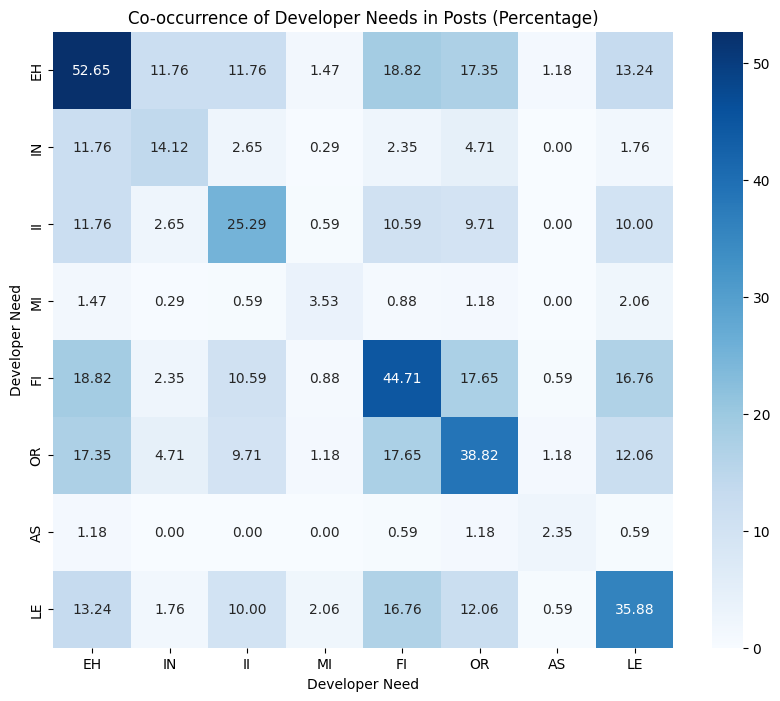

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_sentences_df is your DataFrame and dn_mapping is already defined

# Create a new DataFrame to store the co-occurrence of DNs in posts
dn_cooccurrence = pd.DataFrame(0, index=dn_mapping.keys(), columns=dn_mapping.keys(), dtype=float)

# Fill the co-occurrence matrix
for post_id in all_sentences_df['post_id'].unique():
    post_data = all_sentences_df[all_sentences_df['post_id'] == post_id]
    dn_presence = {dn: (post_data[ri_list].sum(axis=1) > 0).any() for dn, ri_list in dn_mapping.items()}
    for dn1 in dn_mapping.keys():
        for dn2 in dn_mapping.keys():
            if dn_presence[dn1] and dn_presence[dn2]:
                dn_cooccurrence.at[dn1, dn2] += 1

# Convert counts to percentages
total_posts = all_sentences_df['post_id'].nunique()
dn_cooccurrence_percentage = (dn_cooccurrence / total_posts) * 100

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dn_cooccurrence_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.title('Co-occurrence of Developer Needs in Posts (Percentage)')
plt.xlabel('Developer Need')
plt.ylabel('Developer Need')
plt.show()

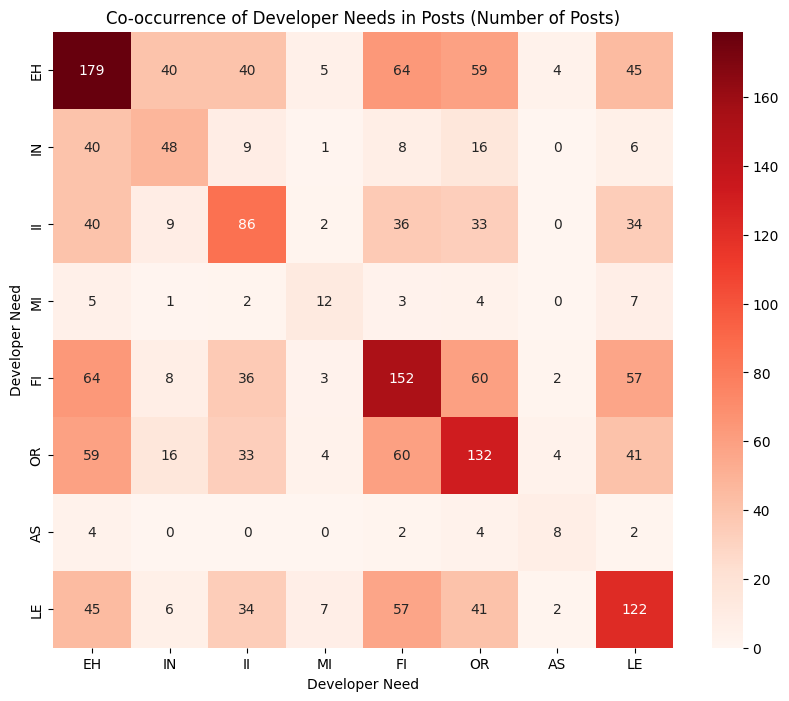

In [147]:
# Create a DataFrame to store whether each post_id has any DN category
dn_presence_df = pd.DataFrame(index=all_sentences_df['post_id'].unique(), columns=dn_mapping.keys(), dtype=bool).fillna(False)

# Fill the DataFrame with DN presence information
for dn, ri_list in dn_mapping.items():
    dn_presence = all_sentences_df.groupby('post_id')[ri_list].sum() > 0
    dn_presence_df[dn] = dn_presence.any(axis=1)

# Create a new DataFrame to store the co-occurrence of DNs in posts
dn_cooccurrence = pd.DataFrame(0, index=dn_mapping.keys(), columns=dn_mapping.keys(), dtype=int)

# Fill the co-occurrence matrix with the number of posts
for dn1 in dn_mapping.keys():
    for dn2 in dn_mapping.keys():
        dn_cooccurrence.at[dn1, dn2] = (dn_presence_df[dn1] & dn_presence_df[dn2]).sum()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dn_cooccurrence, annot=True, cmap='Reds', fmt='d')
plt.title('Co-occurrence of Developer Needs in Posts (Number of Posts)')
plt.xlabel('Developer Need')
plt.ylabel('Developer Need')
plt.show()

### 4. Accepted answers statistics

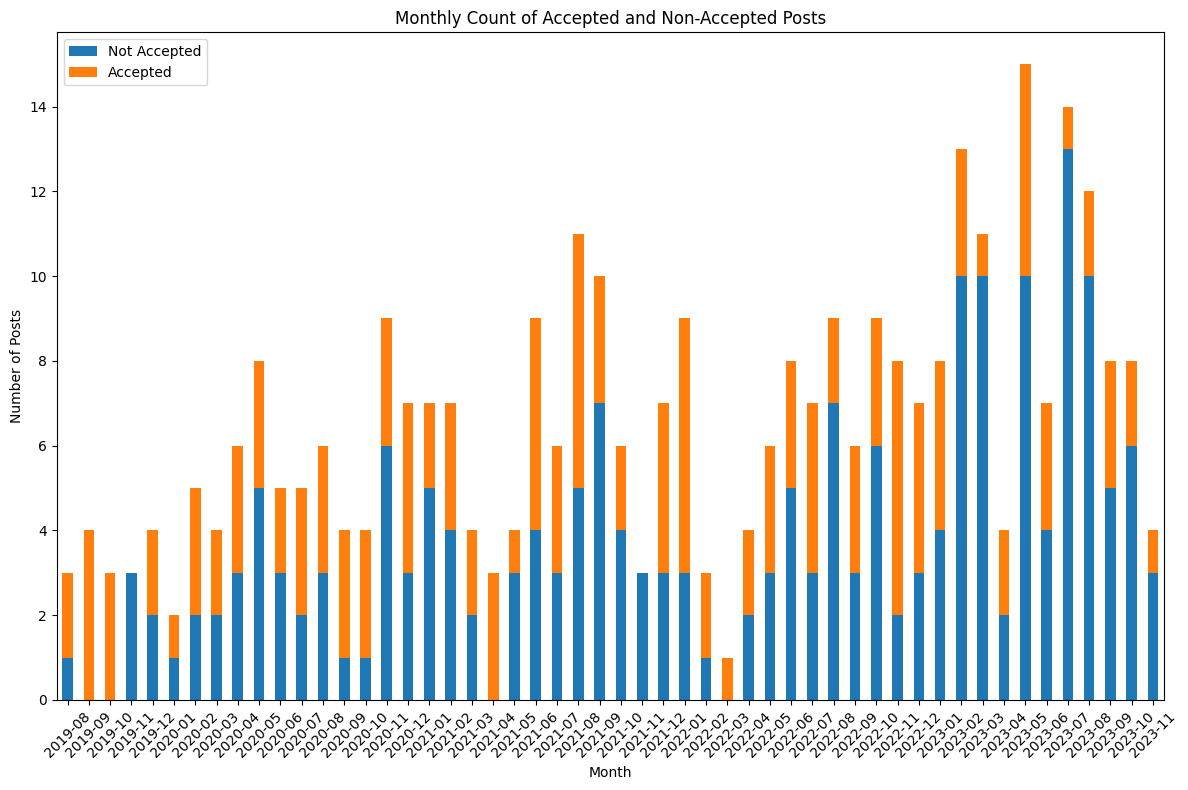

In [148]:
# Convert creation_date to datetime
sample_accepted['creation_date'] = pd.to_datetime(sample_accepted['creation_date'])

# Extract year and month from creation_date
sample_accepted['year_month'] = sample_accepted['creation_date'].dt.to_period('M')

# Create a column to indicate whether a post has an accepted answer or not
sample_accepted['accepted'] = ~sample_accepted['accepted_answer_id'].isna()

# Group by year_month and accepted to get the counts
monthly_counts = sample_accepted.groupby(['year_month', 'accepted']).size().unstack(fill_value=0)

# Plotting the bar plot
monthly_counts.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e'])
plt.title('Monthly Count of Accepted and Non-Accepted Posts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(['Not Accepted', 'Accepted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\shern\AppData\Local\Temp\ipykernel_27108\567766369.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dn_sample_accepted['accepted'] = ~dn_sample_accepted['accepted_answer_id'].isna()
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\567766369.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dn_sample_accepted['accepted'] = ~dn_sample_accepted['accepted_answer_id'].isna()
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\567766369.py:13: SettingWithCopyWarning: 
A value is trying to be set on

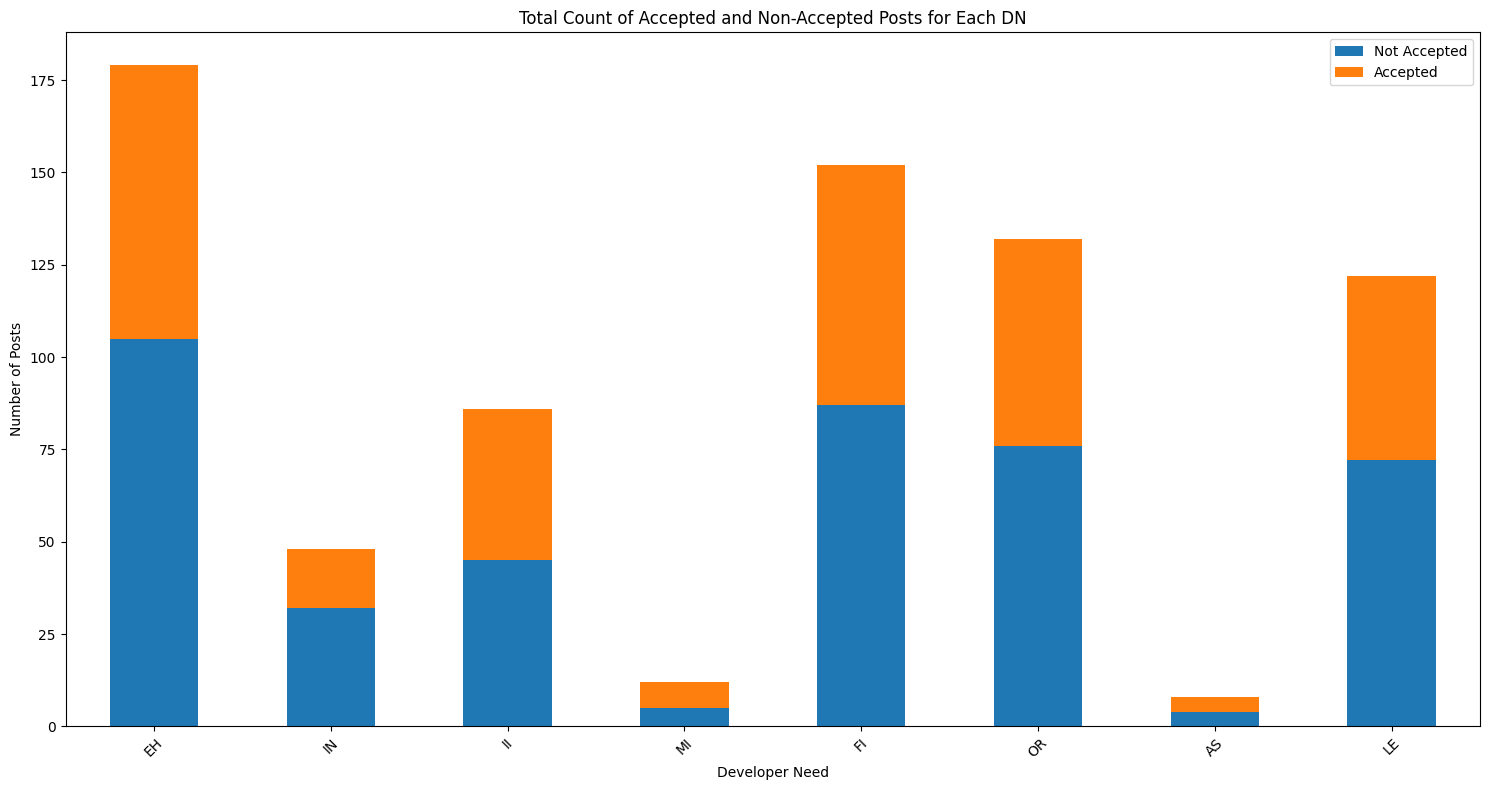

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to get the count of accepted and non-accepted posts for a given DN
def get_dn_post_counts(dn, df, sample_accepted):
    # Filter the DataFrame to include only posts corresponding to the given DN
    dn_posts = df[df[dn_mapping[dn]].sum(axis=1) > 0]
    # Get unique post IDs for the given DN
    dn_post_ids = dn_posts['post_id'].unique()
    # Filter sample_accepted to include only posts corresponding to the given DN
    dn_sample_accepted = sample_accepted[sample_accepted['id'].isin(dn_post_ids)]
    # Create a column to indicate whether a post has an accepted answer or not
    dn_sample_accepted['accepted'] = ~dn_sample_accepted['accepted_answer_id'].isna()
    # Group by accepted to get the counts
    dn_post_counts = dn_sample_accepted.groupby('accepted').size()
    return dn_post_counts

# List of Developer Needs (DN) categories
dn_categories = list(dn_mapping.keys())

# Create a DataFrame to store the counts for each DN
dn_post_counts_df = pd.DataFrame(index=dn_categories, columns=['Not Accepted', 'Accepted']).fillna(0)

# Get the counts for each DN category
for dn in dn_categories:
    dn_post_counts = get_dn_post_counts(dn, all_sentences_df, sample_accepted)
    dn_post_counts_df.loc[dn, 'Not Accepted'] = dn_post_counts.get(False, 0)
    dn_post_counts_df.loc[dn, 'Accepted'] = dn_post_counts.get(True, 0)

# Plotting the bar plot
dn_post_counts_df.plot(kind='bar', stacked=True, figsize=(15, 8), color=['#1f77b4', '#ff7f0e'])
plt.title('Total Count of Accepted and Non-Accepted Posts for Each DN')
plt.xlabel('Developer Need')
plt.ylabel('Number of Posts')
plt.legend(['Not Accepted', 'Accepted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\shern\AppData\Local\Temp\ipykernel_27108\3239099325.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eh_sample_accepted['creation_date'] = pd.to_datetime(eh_sample_accepted['creation_date'])
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\3239099325.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eh_sample_accepted['year_month'] = eh_sample_accepted['creation_date'].dt.to_period('M')
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\3239099325.py:17: SettingWithCopyWarning: 
A value is t

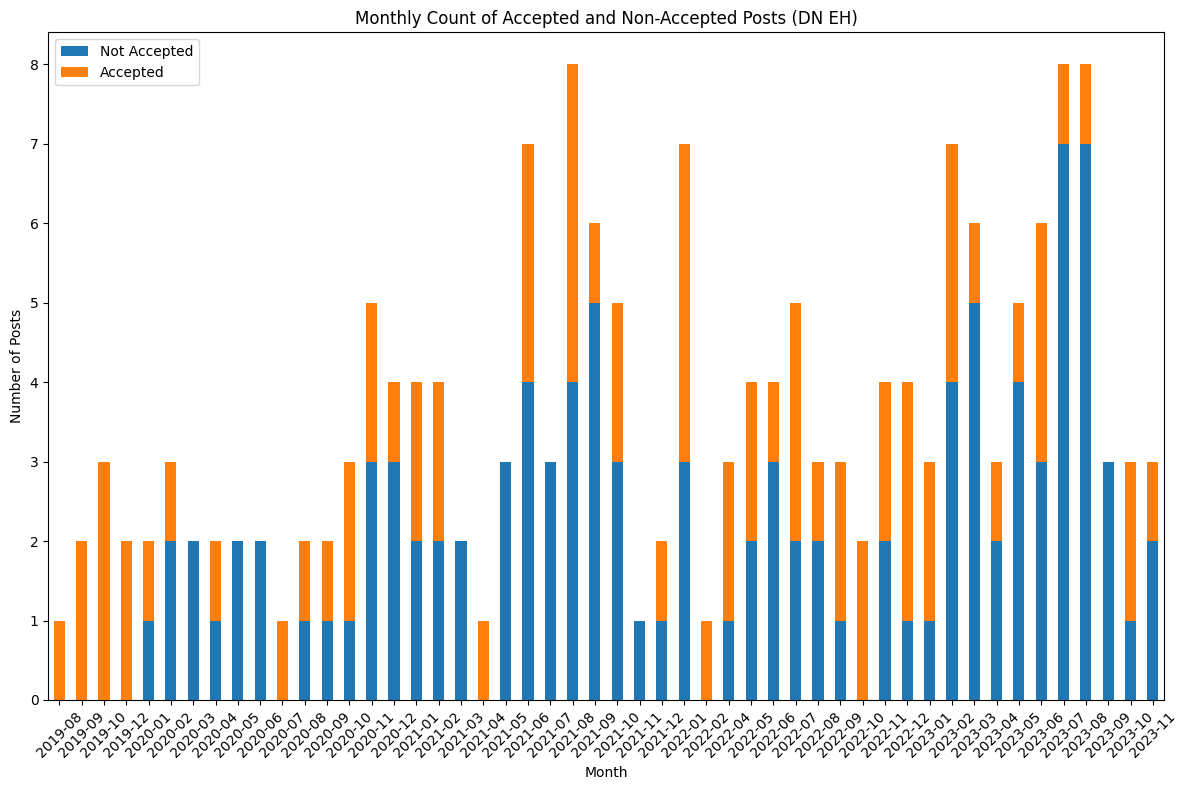

In [149]:
# Filter the DataFrame to include only posts corresponding to DN EH
eh_posts = all_sentences_df[all_sentences_df[dn_mapping['EH']].sum(axis=1) > 0]

# Get unique post IDs for DN EH
eh_post_ids = eh_posts['post_id'].unique()

# Filter sample_accepted to include only posts corresponding to DN EH
eh_sample_accepted = sample_accepted[sample_accepted['id'].isin(eh_post_ids)]

# Convert creation_date to datetime
eh_sample_accepted['creation_date'] = pd.to_datetime(eh_sample_accepted['creation_date'])

# Extract year and month from creation_date
eh_sample_accepted['year_month'] = eh_sample_accepted['creation_date'].dt.to_period('M')

# Create a column to indicate whether a post has an accepted answer or not
eh_sample_accepted['accepted'] = ~eh_sample_accepted['accepted_answer_id'].isna()

# Group by year_month and accepted to get the counts
eh_monthly_counts = eh_sample_accepted.groupby(['year_month', 'accepted']).size().unstack(fill_value=0)

# Plotting the bar plot
eh_monthly_counts.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e'])
plt.title('Monthly Count of Accepted and Non-Accepted Posts (DN EH)')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(['Not Accepted', 'Accepted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\shern\AppData\Local\Temp\ipykernel_27108\195778774.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dn_sample_accepted['creation_date'] = pd.to_datetime(dn_sample_accepted['creation_date'])
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\195778774.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dn_sample_accepted['year_month'] = dn_sample_accepted['creation_date'].dt.to_period('M')
C:\Users\shern\AppData\Local\Temp\ipykernel_27108\195778774.py:17: SettingWithCopyWarning: 
A value is tryi

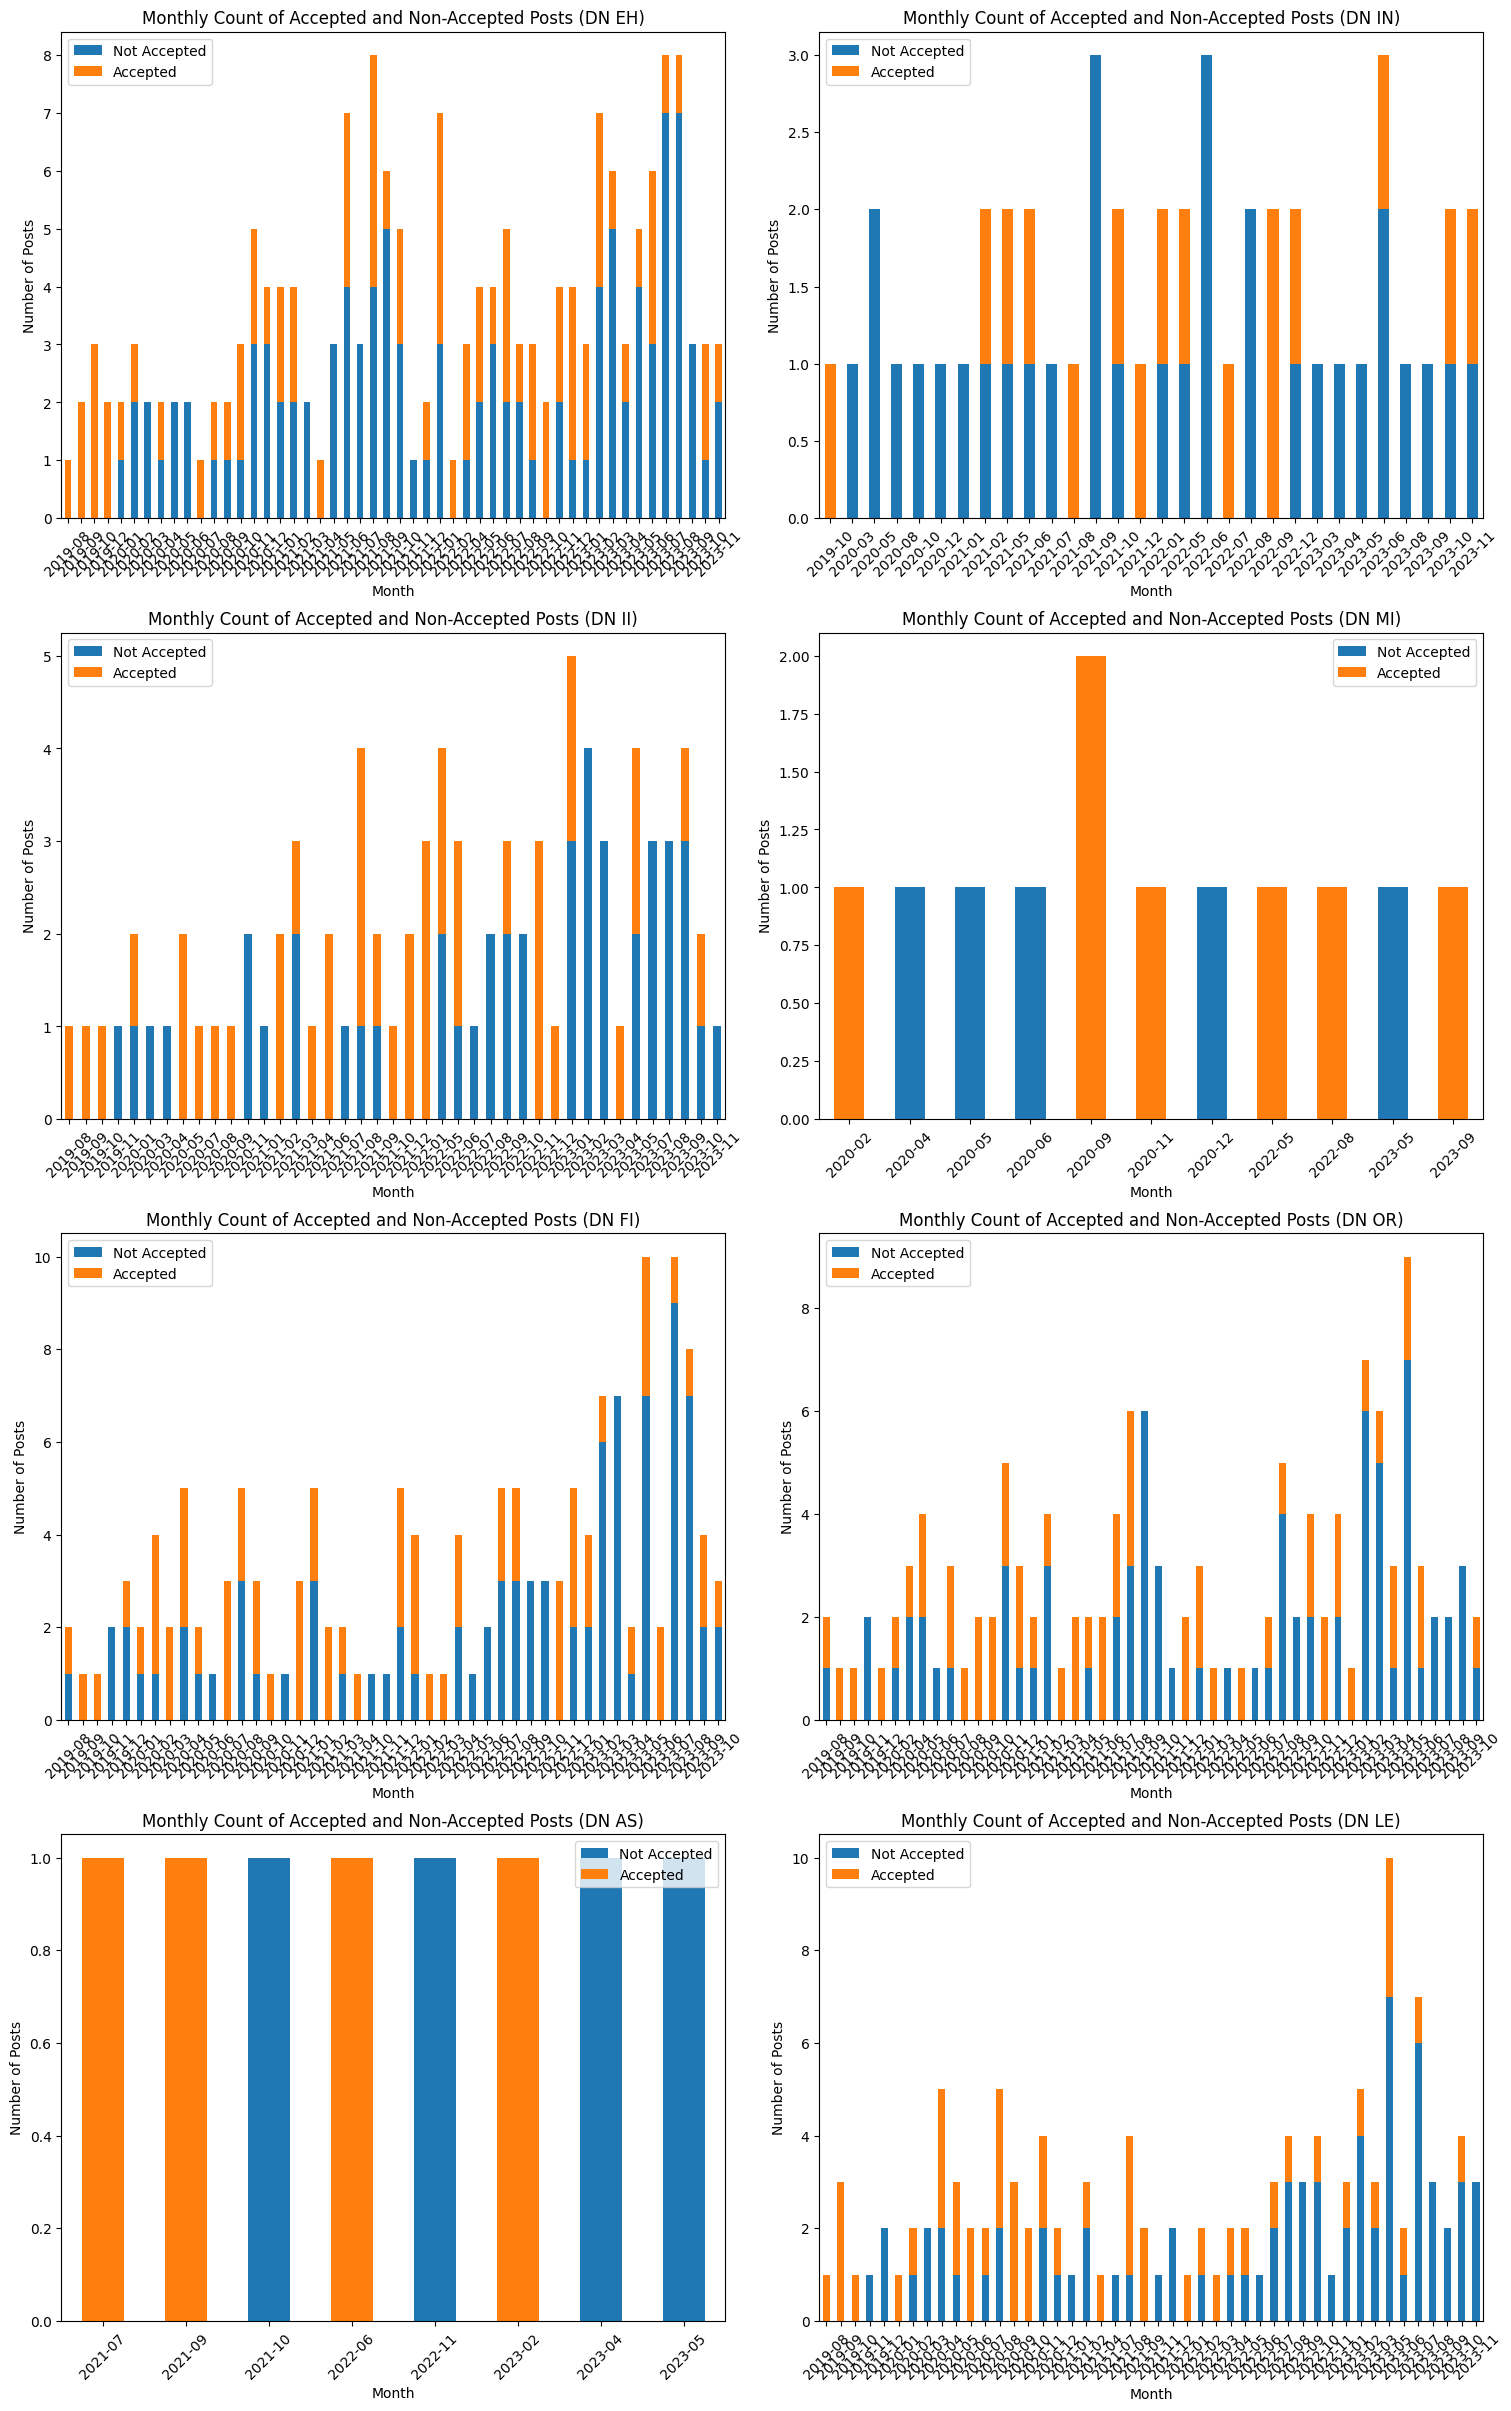

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot the monthly count of accepted and non-accepted posts for a given DN
def get_dn_monthly_counts(dn, df, sample_accepted):
    # Filter the DataFrame to include only posts corresponding to the given DN
    dn_posts = df[df[dn_mapping[dn]].sum(axis=1) > 0]
    # Get unique post IDs for the given DN
    dn_post_ids = dn_posts['post_id'].unique()
    # Filter sample_accepted to include only posts corresponding to the given DN
    dn_sample_accepted = sample_accepted[sample_accepted['id'].isin(dn_post_ids)]
    # Convert creation_date to datetime
    dn_sample_accepted['creation_date'] = pd.to_datetime(dn_sample_accepted['creation_date'])
    # Extract year and month from creation_date
    dn_sample_accepted['year_month'] = dn_sample_accepted['creation_date'].dt.to_period('M')
    # Create a column to indicate whether a post has an accepted answer or not
    dn_sample_accepted['accepted'] = ~dn_sample_accepted['accepted_answer_id'].isna()
    # Group by year_month and accepted to get the counts
    dn_monthly_counts = dn_sample_accepted.groupby(['year_month', 'accepted']).size().unstack(fill_value=0)
    return dn_monthly_counts

# List of Developer Needs (DN) categories
dn_categories = list(dn_mapping.keys())

# Determine the layout of subplots
n_rows = (len(dn_categories) + 1) // 2

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 6), constrained_layout=True)
axes = axes.flatten()

# Plot for each DN category
for i, dn in enumerate(dn_categories):
    dn_monthly_counts = get_dn_monthly_counts(dn, all_sentences_df, sample_accepted)
    dn_monthly_counts.plot(kind='bar', stacked=True, ax=axes[i], color=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'Monthly Count of Accepted and Non-Accepted Posts (DN {dn})')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Number of Posts')
    axes[i].legend(['Not Accepted', 'Accepted'])
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()



----------------------------------------------------------------

## Appendix

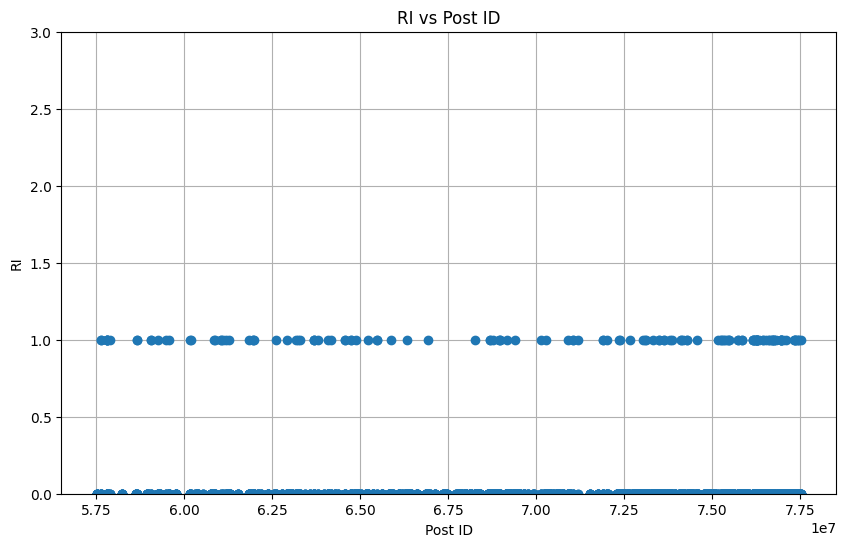

In [28]:
import matplotlib.pyplot as plt

# Plot Completeness vs post_id
plt.figure(figsize=(10, 6))
plt.plot(all_sentences_df['post_id'], all_sentences_df['LE1'], marker='o', linestyle='None')
plt.xlabel('Post ID')
plt.ylabel('RI')
plt.title('RI vs Post ID')
plt.ylim(0,3)
plt.grid(True)
plt.show()

In [29]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# List of sentences
sentences = [
    "Is there a way to deploy code to AWS EC2 without using Elastic Beanstalk?",
    "Is there a way to set the password so the runner stops asking me every single time?",
    "Is there an off the self way to report all Checkstyle XML warnings and errors as pull-request",
    "Maybe there is something fundamental that I don't quite get regarding port forwarding.",
    "I want to know if is there any way to generate the EJbs code without a server installation available, and if not, if is there any way to have an installation of the server available in the pipeline in order to this work (pipeline is running over ubuntu-18.04)"
]

# Function to extract POS tags from a sentence
def extract_pos_tags(sentence):
    doc = nlp(sentence.lower())
    return ' '.join([token.pos_ for token in doc])

# Extract POS tags for each sentence
pos_sentences = [extract_pos_tags(sentence) for sentence in sentences]

# Vectorize the POS tag sequences
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(pos_sentences)

# Cluster the sentences using KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

# Print the clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for idx, label in enumerate(kmeans.labels_):
        if label == i:
            print(f"  {sentences[idx]}")


C:\Users\shern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
  Is there a way to deploy code to AWS EC2 without using Elastic Beanstalk?
  Is there an off the self way to report all Checkstyle XML warnings and errors as pull-request
Cluster 1:
  I want to know if is there any way to generate the EJbs code without a server installation available, and if not, if is there any way to have an installation of the server available in the pipeline in order to this work (pipeline is running over ubuntu-18.04)
Cluster 2:
  Maybe there is something fundamental that I don't quite get regarding port forwarding.
Cluster 3:
  Is there a way to set the password so the runner stops asking me every single time?


In [30]:
all_sentences_df.head(15)

id   post_id source  \
sentence_id                        
0             0  57503578  title   
1             0  57503578   body   
2             0  57503578   body   
3             0  57503578   body   
4             0  57503578   body   
5             0  57503578   body   
6             0  57503578   body   
7             1  57509118  title   
8             1  57509118   body   
9             1  57509118   body   
10            1  57509118   body   
11            1  57509118   body   
12            1  57509118   body   
13            2  57639507  title   
14            2  57639507   body   

                                                      sentence  AS1  EH1  EH2  \
sentence_id                                                                     
0            Making pull requests to a GitHub repository au...    0    0    0   
1            I have a file in a GitHub repository that need...    0    0    0   
2            As part of a -LINK-, I want to have a bot runn...    0    0    0   
3            I have a suspicion that the -LINK- can help me...    0    0    0   
4            I see some official automation workflows that ...    0    0    0   
5            If I wanted to run an arbitrary command and ma...    0    0    0   
6                                Any pointers are appreciated.    0    0    0   
7                      New GitHub actions run in empty folders    0    0    0   
8            I am working with new GitHub actions, idea of ...    0    0    0   
9                                                      -CODE-.    0    0    0   
10           At the moment it successfully gets to a checko...    0    1    0   
11                                                    -BLOCK-.    0    0    0   
12           Judging by this checkout either failed or I am...    0    0    0   
13            How to access a service in Github Actions CI/CD?    0    0    0   
14           I'm trying to set up a CI/CD pipeline in GitHu...    0    0    0   

             EH3  EH4  EH5  ...  LE2  LE3  MI1  OR1  OR2  OR3  OR4  OR5  OR6  \
sentence_id                 ...                                                
0              0    0    0  ...    0    0    0    0    0    0    0    0    0   
1              0    0    0  ...    0    0    0    0    0    0    0    0    0   
2              0    0    0  ...    0    0    0    0    0    0    0    0    0   
3              0    0    0  ...    0    0    0    0    0    0    0    0    0   
4              0    0    0  ...    0    0    0    0    0    0    0    0    0   
5              0    0    0  ...    0    0    0    0    0    0    0    0    1   
6              0    0    0  ...    0    0    0    0    0    0    0    0    0   
7              0    0    0  ...    0    0    0    0    0    0    0    0    0   
8              0    0    0  ...    0    0    0    0    0    0    0    0    0   
9              0    0    0  ...    0    0    0    0    0    0    0    0    0   
10             0    0    0  ...    0    0    0    0    0    0    0    0    0   
11             0    0    0  ...    0    0    0    0    0    0    0    0    0   
12             0    0    0  ...    0    0    0    0    0    1    0    0    0   
13             0    0    0  ...    0    0    0    0    0    0    0    0    0   
14             0    0    0  ...    0    0    0    0    0    0    0    0    0   

             OR7  
sentence_id       
0              0  
1              0  
2              0  
3              0  
4              0  
5              0  
6              0  
7              0  
8              0  
9              0  
10             0  
11             0  
12             0  
13             0  
14             0  

[15 rows x 28 columns]

In [47]:
sample_accepted

id  post_type_id  accepted_answer_id  parent_id  \
0    57503578             1                 NaN        NaN   
1    57509118             1          57521953.0        NaN   
2    57639507             1          57639714.0        NaN   
3    57806624             1          57806894.0        NaN   
4    57808152             1          59022667.0        NaN   
..        ...           ...                 ...        ...   
335  77395114             1          77395417.0        NaN   
336  77431693             1                 NaN        NaN   
337  77446605             1          77446960.0        NaN   
338  77469265             1                 NaN        NaN   
339  77519735             1                 NaN        NaN   

           creation_date  score  view_count  \
0    2019-08-15 00:30:14     13        7788   
1    2019-08-15 11:42:14      4        2302   
2    2019-08-24 16:02:24      4         819   
3    2019-09-05 13:29:41     80       35589   
4    2019-09-05 14:56:14     11        4658   
..                   ...    ...         ...   
335  2023-10-31 10:30:28      0          62   
336  2023-11-06 14:04:11      0          32   
337  2023-11-08 14:49:09      1          95   
338  2023-11-12 14:11:32      0          28   
339  2023-11-21 00:52:54      1         304   

                                             post_body  owner_user_id  \
0    <p>I have a file in a GitHub repository that n...        54929.0   
1    <p>I am working with new GitHub actions, idea ...       911930.0   
2    <p>I'm trying to set up a CI/CD pipeline in Gi...      1341734.0   
3    <p>I'm using GitHub Actions to build my projec...      3231778.0   
4    <p>I'm trying out GitHub Actions to build my F...      3231778.0   
..                                                 ...            ...   
335  <p>I wanted to experiment with GitHub Actions:...     11186407.0   
336  <p>Basically as it says in the title.</p>&#xA;...     22436104.0   
337  <p>I have my unittests in a top level <code>te...       471136.0   
338  <p>I'm facing an issue with accessing metadata...     22902806.0   
339  <p>I'm uploading the changes in NestJS via Git...     20892191.0   

     last_editor_user_id       last_edit_date   last_activity_date  \
0                    NaN                 None  2023-04-05 01:42:41   
1                    NaN                 None  2019-08-16 09:15:48   
2                    NaN                 None  2022-04-06 11:40:39   
3                    NaN                 None  2022-03-13 19:24:54   
4              3231778.0  2019-09-05 15:48:37  2022-09-14 10:01:40   
..                   ...                  ...                  ...   
335                  NaN                 None  2023-10-31 13:15:41   
336            9938317.0  2023-11-06 15:35:14  2023-11-06 15:35:14   
337                  NaN                 None  2023-11-08 15:41:57   
338                  NaN                 None  2023-11-12 14:11:32   
339            3001761.0  2023-11-21 08:01:48  2023-11-21 08:01:48   

                                            post_title  \
0    Making pull requests to a GitHub repository au...   
1              New GitHub actions run in empty folders   
2     How to access a service in Github Actions CI/CD?   
3    GitHub Actions - How to build project in sub-d...   
4         How to build Flutter in GitHub Actions CI/CD   
..                                                 ...   
335  GitHub Actions generated docker image results ...   
336  GitHub Actions VS code extension gives access ...   
337  Running Python Poetry unit test in Github actions   
338  How to Retrieve Metadata of AWS-Stored Audio F...   
339    Dependency installation error in GitHub Actions   

                                                  tags  answer_count  \
0                             <github><github-actions>             1   
1                  <github><github-actions><github-ci>             1   
2                     <github><elixir><github-actions>             1  